**Road Sign Detection**

Understanding the impact of data augmentation and batch normalization.

In [3]:
import os
import torch
import torch.nn as nn
from torch_snippets import *
from torchvision import transforms as T
from google.colab import files

In [2]:
!pip install -qq torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 105.5 MB/s eta 0:00:00


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
if not os.path.exists('GTSRB'):
  !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
  !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

  !unzip -q GTSRB_Final_Training_Images.zip
  !unzip -q GTSRB_Final_Test_Images.zip

  !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
  !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

--2024-08-16 08:58:29--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2024-08-16 08:58:29 (66.0 MB/s) - ‘signnames.csv’ saved [999/999]



**Assign class IDs to possible output classes**

In [7]:
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

In [8]:
classIds

{'00000': 'Speed limit (20km/h)',
 '00001': 'Speed limit (30km/h)',
 '00002': 'Speed limit (50km/h)',
 '00003': 'Speed limit (60km/h)',
 '00004': 'Speed limit (70km/h)',
 '00005': 'Speed limit (80km/h)',
 '00006': 'End of speed limit (80km/h)',
 '00007': 'Speed limit (100km/h)',
 '00008': 'Speed limit (120km/h)',
 '00009': 'No passing',
 '00010': 'No passing for vechiles over 3.5 metric tons',
 '00011': 'Right-of-way at the next intersection',
 '00012': 'Priority road',
 '00013': 'Yield',
 '00014': 'Stop',
 '00015': 'No vechiles',
 '00016': 'Vechiles over 3.5 metric tons prohibited',
 '00017': 'No entry',
 '00018': 'General caution',
 '00019': 'Dangerous curve to the left',
 '00020': 'Dangerous curve to the right',
 '00021': 'Double curve',
 '00022': 'Bumpy road',
 '00023': 'Slippery road',
 '00024': 'Road narrows on the right',
 '00025': 'Road work',
 '00026': 'Traffic signals',
 '00027': 'Pedestrians',
 '00028': 'Children crossing',
 '00029': 'Bicycles crossing',
 '00030': 'Beware of

**Transformation Pipeline on top of images without any augmentation**

In [9]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2),
    # contrast=(0.8,1.2),
    # saturation=(0.8,1.2),
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
 ])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
 ])

# The commented part of the code is what should be uncomment and re-run to understand the scenrio of performing data augmentation.

**Dataset class**

In [10]:
class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

**Create training and validation datasets and dataloader**

In [11]:
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[08/16/24 08:59:58] INFO     29406                                                                                                ]8;id=658732;file://<ipython-input-10-3b18c3e53228>:7\<ipython-input-10-3b18c3e53228>]8;;\:]8;id=660842;file://<ipython-input-10-3b18c3e53228>:7#__init__:7\__init__:7]8;;\

                    INFO     9803                                                                                                 ]8;id=267401;file://<ipython-input-10-3b18c3e53228>:7\<ipython-input-10-3b18c3e53228>]8;;\:]8;id=439178;file://<ipython-input-10-3b18c3e53228>:7#__init__:7\__init__:7]8;;\

In [13]:
print(f'Total images: {len(all_files)}, training Images: {len(trn_ds)}, Testing Images: {len(val_ds)}')

Total images: 39209, training Images: 29406, Testing Images: 9803


**Define the model**

In [14]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

# Make sure to uncomment the line in bold when testing the model with the BatchNormalization scenario.

**Functions to train and validate on a batch of data**

In [15]:
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

**Model Training over increasing epochs**

EPOCH: 1.000  val_acc: 0.518  val_loss: 1.478  trn_acc: 0.310  trn_loss: 2.341  (37.98s - 1861.05s remaining)
EPOCH: 2.000  val_acc: 0.719  val_loss: 0.861  trn_acc: 0.628  trn_loss: 1.128  (74.04s - 1776.88s remaining)
EPOCH: 3.000  val_acc: 0.766  val_loss: 0.709  trn_acc: 0.749  trn_loss: 0.757  (102.07s - 1599.15s remaining)
EPOCH: 4.000  val_acc: 0.815  val_loss: 0.569  trn_acc: 0.796  trn_loss: 0.612  (126.59s - 1455.84s remaining)
EPOCH: 5.000  val_acc: 0.841  val_loss: 0.488  trn_acc: 0.823  trn_loss: 0.534  (153.83s - 1384.44s remaining)
EPOCH: 6.000  val_acc: 0.850  val_loss: 0.468  trn_acc: 0.845  trn_loss: 0.470  (179.78s - 1318.36s remaining)
EPOCH: 7.000  val_acc: 0.870  val_loss: 0.404  trn_acc: 0.860  trn_loss: 0.426  (208.19s - 1278.88s remaining)
EPOCH: 8.000  val_acc: 0.864  val_loss: 0.415  trn_acc: 0.867  trn_loss: 0.407  (232.97s - 1223.10s remaining)
EPOCH: 9.000  val_acc: 0.855  val_loss: 0.455  trn_acc: 0.876  trn_loss: 0.371  (259.24s - 1180.98s remaining)
EPO

100%|██████████| 151/151 [00:03<00:00, 39.35it/s]


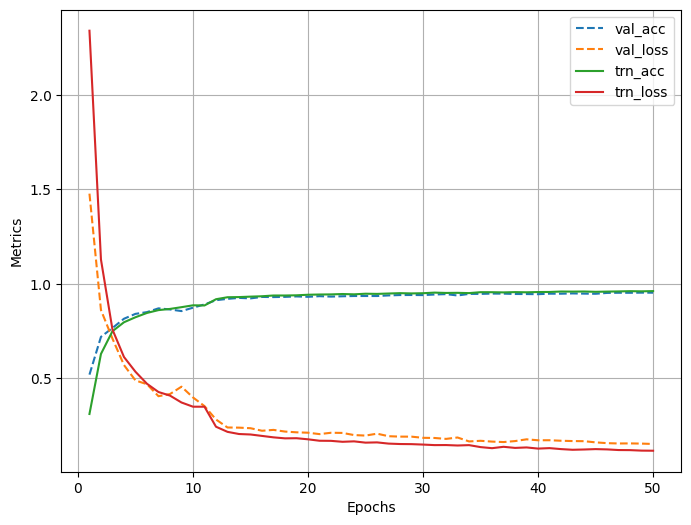

[08/16/24 09:24:10] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 2.29e+00 seconds                         ]8;id=655902;file://<ipython-input-16-4acfb00f8f41>:22\<ipython-input-16-4acfb00f8f41>]8;;\:<cell line: 22>:22

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')
files.download('no-aug-no-bn.log')

**Save the model weights**

In [18]:
torch.save(model.state_dict(), 'model_weights.pth')